# Titanic Survival Prediction (Machine Learning)

This project builds a predictive model for the Kaggle Titanic dataset using:
- Feature engineering (Titles, FamilySize, IsAlone, CabinKnown)
- sklearn Pipelines
- Random Forest Classifier
- Cross-validation and evaluation metrics

## Files
- train.csv, test.csv → Dataset
- titanic_model.ipynb → Notebook with preprocessing, model training, evaluation
- submission.csv → Kaggle-ready predictions

## How to Run
1. Install dependencies: `pip install -r requirements.txt`
2. Run the notebook or python scripts in the src/ directory.

"""

with open("README.md", "w") as f:
    f.write(readme)


Saving train.csv to train (3).csv
Saving test.csv to test (3).csv
Saving gender_submission.csv to gender_submission (3).csv
Train shape: (891, 12)
Test shape : (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



Engineered feature sample:


,PassengerId,Name,Title,FamilySize,IsAlone,CabinKnown
0,1,"Braund, Mr. Owen Harris",Mr,2,0,0
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs,2,0,1
2,3,"Heikkinen, Miss. Laina",Miss,1,1,0
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs,2,0,1
4,5,"Allen, Mr. William Henry",Mr,1,1,0



=== Validation Performance ===
Accuracy   : 0.8045
ROC AUC    : 0.8236

Classification report:
               precision    recall  f1-score   support

           0     0.8319    0.8545    0.8430       110
           1     0.7576    0.7246    0.7407        69

    accuracy                         0.8045       179
   macro avg     0.7947    0.7896    0.7919       179
weighted avg     0.8032    0.8045    0.8036       179

Confusion matrix:
 [[94 16]
 [19 50]]

5-fold CV accuracy scores: [0.8436 0.809  0.7865 0.8202 0.8202]
CV accuracy mean: 0.8159


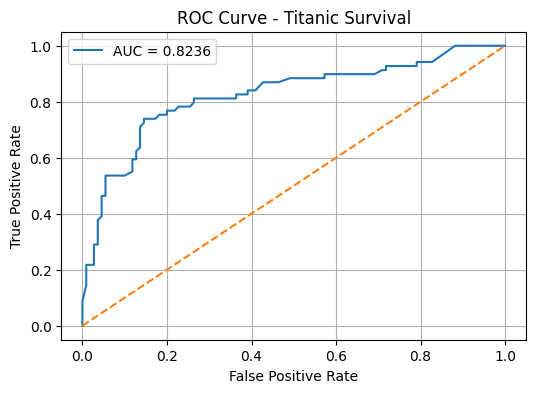


Top 15 feature importances:


,feature,importance
0,Fare,0.209771
1,Age,0.197485
2,Title_Mr,0.087416
3,Sex_male,0.087343
4,Sex_female,0.085090
5,FamilySize,0.039868
6,Pclass_3,0.038883
7,CabinKnown_1,0.033031
8,CabinKnown_0,0.030235
9,Title_Miss,0.027415



Saved submission.csv


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
from google.colab import files
uploaded = files.upload()  # Select train.csv and test.csv


import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
)


train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train shape:", train.shape)
print("Test shape :", test.shape)
display(train.head())

def extract_title(name: str) -> str:
    m = re.search(r",\s*([^\.]+)\.", name)
    return m.group(1).strip() if m else "Unknown"

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Title
    df["Title"] = df["Name"].apply(extract_title)
    df["Title"] = df["Title"].replace({"Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs"})
    rare_titles = [
        "Lady", "Countess", "Capt", "Col", "Don", "Dr", "Major",
        "Rev", "Sir", "Jonkheer", "Dona"
    ]
    df["Title"] = df["Title"].apply(
        lambda t: t
        if t in ["Mr", "Mrs", "Miss", "Master"]
        else ("Rare" if t in rare_titles or len(t) > 5 else t)
    )

    # Family features
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)

    # Cabin known
    df["CabinKnown"] = (~df["Cabin"].isna()).astype(int)

    # Optional log Fare
    df["Fare_log"] = np.log1p(df["Fare"].fillna(0))

    return df

train_fe = add_features(train)
test_fe = add_features(test)

print("\nEngineered feature sample:")
display(train_fe[["PassengerId", "Name", "Title", "FamilySize", "IsAlone", "CabinKnown"]].head())


FEATURES = [
    "Pclass", "Sex", "Age", "SibSp", "Parch",
    "Fare", "Embarked", "Title", "FamilySize",
    "IsAlone", "CabinKnown"
]
TARGET = "Survived"

X = train_fe[FEATURES].copy()
y = train_fe[TARGET].copy()
X_test = test_fe[FEATURES].copy()


numeric_features = ["Age", "SibSp", "Parch", "Fare", "FamilySize"]
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_features = ["Pclass", "Sex", "Embarked", "Title", "IsAlone", "CabinKnown"]
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )),
])


X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

clf.fit(X_train, y_train)


y_pred = clf.predict(X_val)
y_proba = clf.predict_proba(X_val)[:, 1]

acc = accuracy_score(y_val, y_pred)
roc = roc_auc_score(y_val, y_proba)

print("\n=== Validation Performance ===")
print(f"Accuracy   : {acc:.4f}")
print(f"ROC AUC    : {roc:.4f}")
print("\nClassification report:\n", classification_report(y_val, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_val, y_pred))

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(clf, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
print("\n5-fold CV accuracy scores:", np.round(cv_scores, 4))
print("CV accuracy mean:", np.round(cv_scores.mean(), 4))

# ROC curve
fpr, tpr, _ = roc_curve(y_val, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Titanic Survival")
plt.legend()
plt.grid(True)
plt.show()


ohe = clf.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"]
ohe_feature_names = ohe.get_feature_names_out(categorical_features)
feature_names = numeric_features + list(ohe_feature_names)

rf = clf.named_steps["clf"]
importances = rf.feature_importances_

fi = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

print("\nTop 15 feature importances:")
display(fi.head(15))


clf.fit(X, y)
test_preds = clf.predict(X_test).astype(int)

submission = pd.DataFrame({
    "PassengerId": test_fe["PassengerId"],
    "Survived": test_preds,
})

submission.to_csv("submission.csv", index=False)
print("\nSaved submission.csv")

display(submission.head())


files.download("submission.csv")


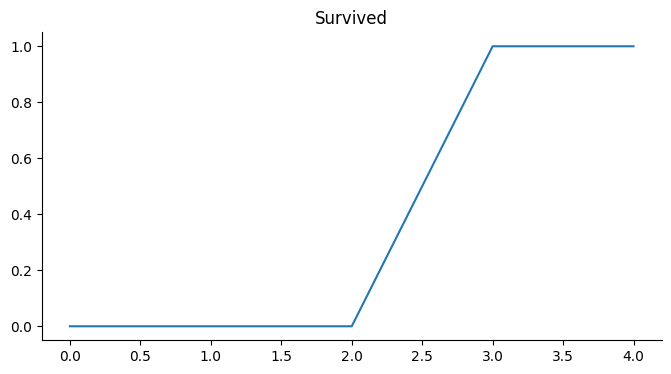

In [15]:
from matplotlib import pyplot as plt
_df_6['Survived'].plot(kind='line', figsize=(8, 4), title='Survived')
plt.gca().spines[['top', 'right']].set_visible(False)

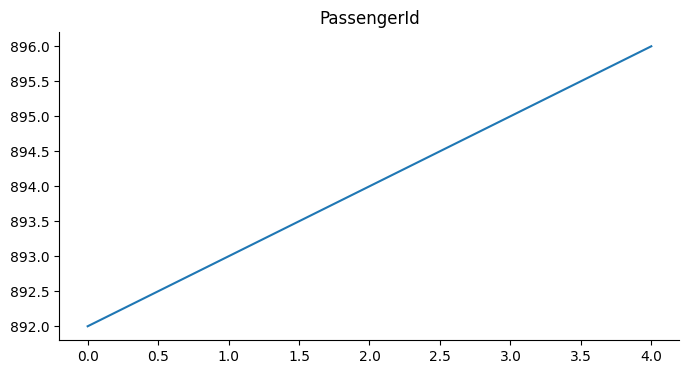

In [16]:
from matplotlib import pyplot as plt
_df_5['PassengerId'].plot(kind='line', figsize=(8, 4), title='PassengerId')
plt.gca().spines[['top', 'right']].set_visible(False)

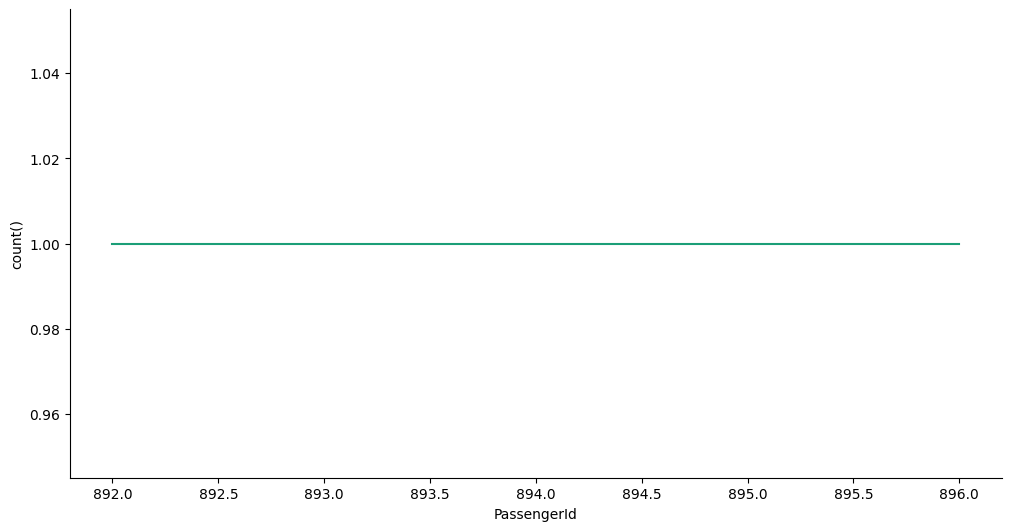

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['PassengerId']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'PassengerId'}, axis=1)
              .sort_values('PassengerId', ascending=True))
  xs = counted['PassengerId']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('PassengerId', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('PassengerId')
_ = plt.ylabel('count()')

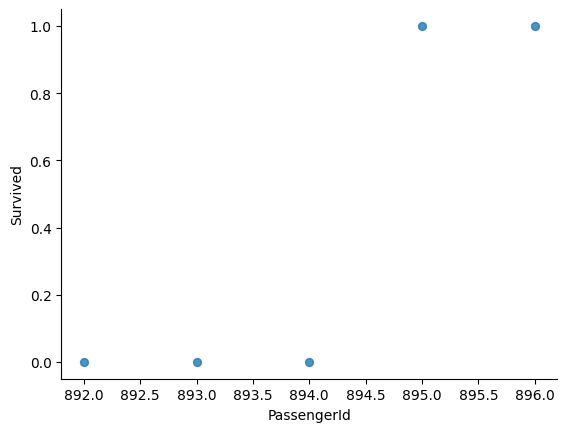

In [18]:
from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='PassengerId', y='Survived', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

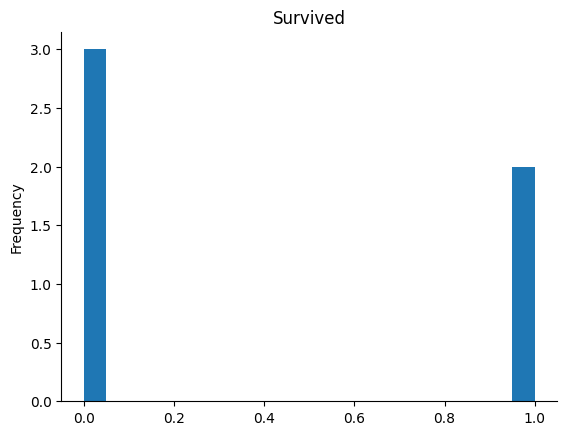

In [19]:
from matplotlib import pyplot as plt
_df_1['Survived'].plot(kind='hist', bins=20, title='Survived')
plt.gca().spines[['top', 'right',]].set_visible(False)

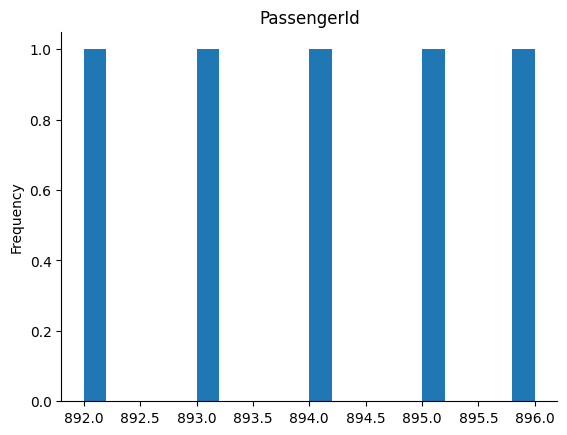

In [20]:
from matplotlib import pyplot as plt
_df_0['PassengerId'].plot(kind='hist', bins=20, title='PassengerId')
plt.gca().spines[['top', 'right',]].set_visible(False)